# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera
***

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>
***

In this project we will try to find an optimal location for an ATM machine. This report will be targeted to the executive team of a Bank interested in investing on setting up ATMs across neighborhoods in Chennai, India.

Location of ATM machines should be those with high foot traffic. The presence of diverse set of venues in a neighborhood is expected to cater to wide variety of needs and thus attract more people. An analysis of each area will be provided so that best possible locations can be chosen by stakeholders.

## Data <a name="data"></a>
***

Based on definition of our problem, factors that will influence our decission are:
* number of venues in the neighborhood
* diversity of venues (presence of various categories)

We will be using the following data sources :
* a csv file containing a set of neighborhoods under consideration by the bank.
* venue information and their type and location in every neighborhood will be obtained using **Foursquare API**


In [1]:
#Import required packages
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import folium
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans # import k-means from clustering stage
import matplotlib.cm as cm
import matplotlib.colors as colors

Let's load the neighborhood data from the csv file.

In [2]:
data = pd.read_csv('Geospatial_Coordinates.csv')
data

,Neighborhood,Latitude,Longitude
0,Anna Nagar,13.0891,80.2096
1,Perungudi,12.9654,80.2461
2,Adyar,13.0012,80.2565
3,T. Nagar,13.0405,80.2337
4,Guindy,13.0102,80.2157
5,Velachery,12.9760,80.2212
6,Taramani,12.9814,80.2432
7,Thoraipakkam,12.9416,80.2362
8,Injambakkam,12.9198,80.2511
9,Koyambedu,13.0692,80.1914


Let's generate a map of Chennai, India.

In [3]:
latitude = 13.0827
longitude = 80.2707

chennai_map = folium.Map(location=[latitude, longitude], zoom_start=11)

chennai_map

Now, we will superimpose the neighborhoods under consideration on the map and add some markers.

In [4]:
for lat, lng, neighborhood in zip(data['Latitude'], data['Longitude'], data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(chennai_map)  
    
chennai_map

Let's initialize Foursquare credentials.

In [5]:
CLIENT_ID = '52DCGFNDNIJDG1LEUOIDHPC3XIUJNUJ2HMBWIQK0XDINT5EY'
CLIENT_SECRET = '4CDAP035NLFQRTIPWHU52KE41NNZLECOC4VIV4SMSWIV3DS1'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 52DCGFNDNIJDG1LEUOIDHPC3XIUJNUJ2HMBWIQK0XDINT5EY
CLIENT_SECRET:4CDAP035NLFQRTIPWHU52KE41NNZLECOC4VIV4SMSWIV3DS1


## Methodology : <a name="methodology"></a>

In [6]:
data.loc[0, 'Neighborhood']

'Anna Nagar'

In [7]:
neighborhood_latitude = data.loc[0, 'Latitude']
neighborhood_longitude = data.loc[0, 'Longitude']

neighborhood_name = data.loc[0, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Anna Nagar are 13.0891, 80.2096.


In [8]:
LIMIT = 50

radius = 1000

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=52DCGFNDNIJDG1LEUOIDHPC3XIUJNUJ2HMBWIQK0XDINT5EY&client_secret=4CDAP035NLFQRTIPWHU52KE41NNZLECOC4VIV4SMSWIV3DS1&v=20180605&ll=13.0891,80.2096&radius=1000&limit=50'

Let's make an api call with the generated URL. JSON data is stored in results.

In [9]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c7f7d086a60714c84029b27'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Chennai',
  'headerFullLocation': 'Chennai',
  'headerLocationGranularity': 'city',
  'totalResults': 75,
  'suggestedBounds': {'ne': {'lat': 13.098100009000008,
    'lng': 80.21882282247698},
   'sw': {'lat': 13.080099990999992, 'lng': 80.20037717752301}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e0bcdc4a809638b00f1c11d',
       'name': 'Shankar Chat Bhandar',
       'location': {'lat': 13.086592572118786,
        'lng': 80.21025280315361,
        'labeledLatLngs': [{'label': 'display',
          'lat': 13.086592572118786,
          'lng': 80.21025280315361}],
 

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Shankar Chat Bhandar,Snack Place,13.086593,80.210253
1,Anna Nagar Tower Park,Park,13.086571,80.213627
2,Kumarakom,Indian Restaurant,13.090402,80.212701
3,Starbucks,Coffee Shop,13.084861,80.212447
4,99°F Fitness Studio,Gym,13.084923,80.211343


In [12]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

50 venues were returned by Foursquare.


Let's obtain nearby venue information for all neighborhoods under consideration.

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
chennai_venues = getNearbyVenues(names= data['Neighborhood'],latitudes= data['Latitude'],longitudes= data['Longitude'] )

Anna Nagar
Perungudi
Adyar
T. Nagar
Guindy
Velachery
Taramani
Thoraipakkam
Injambakkam
Koyambedu
Triplicane
Pallavaram
Tambaram
Palavakkam
Vadapalani


In [15]:
print(chennai_venues.shape)
chennai_venues.head()

(169, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Anna Nagar,13.0891,80.2096,Shankar Chat Bhandar,13.086593,80.210253,Snack Place
1,Anna Nagar,13.0891,80.2096,Kumarakom,13.090402,80.212701,Indian Restaurant
2,Anna Nagar,13.0891,80.2096,amala mess,13.085722,80.208533,Fast Food Restaurant
3,Anna Nagar,13.0891,80.2096,Jack 'N' Jill,13.092006,80.210388,Fast Food Restaurant
4,Anna Nagar,13.0891,80.2096,Ooty Vegetable & Fruits,13.089661,80.210361,Market


In [16]:
chennai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adyar,20,20,20,20,20,20
Anna Nagar,18,18,18,18,18,18
Guindy,5,5,5,5,5,5
Injambakkam,6,6,6,6,6,6
Koyambedu,4,4,4,4,4,4
Palavakkam,5,5,5,5,5,5
Pallavaram,4,4,4,4,4,4
Perungudi,8,8,8,8,8,8
T. Nagar,28,28,28,28,28,28


Let's see the number of venues returned by Foursquare for each neighborhood in consideration.

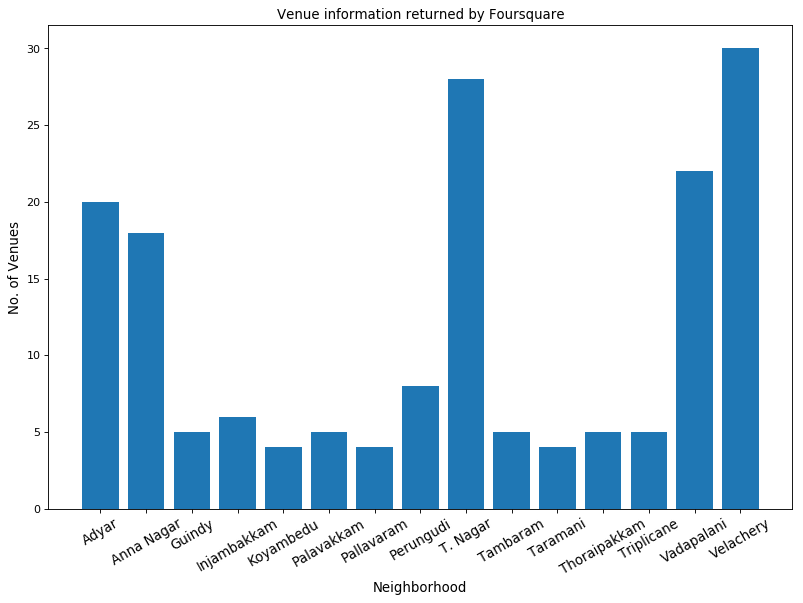

In [17]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

plt.bar(chennai_venues.groupby('Neighborhood').count().index, chennai_venues.groupby('Neighborhood').count().Venue, width=0.8)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('No. of Venues', fontsize=12)
plt.xticks(fontsize=12, rotation=30)
plt.title('Venue information returned by Foursquare')
plt.show()

Let's try to understand the diversity of venues in the given neighborhoods.

In [18]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 64 uniques categories.


In [19]:
#We take count of unique catergories in each neighborhood
category_count = {}
for name in data.Neighborhood.values:
    category_list = list (chennai_venues[chennai_venues['Neighborhood']==name]['Venue Category'].unique())
    category_count[name] = len(category_list)

category_count

{'Anna Nagar': 14,
 'Perungudi': 7,
 'Adyar': 14,
 'T. Nagar': 15,
 'Guindy': 5,
 'Velachery': 16,
 'Taramani': 4,
 'Thoraipakkam': 5,
 'Injambakkam': 6,
 'Koyambedu': 3,
 'Triplicane': 3,
 'Pallavaram': 4,
 'Tambaram': 5,
 'Palavakkam': 4,
 'Vadapalani': 18}

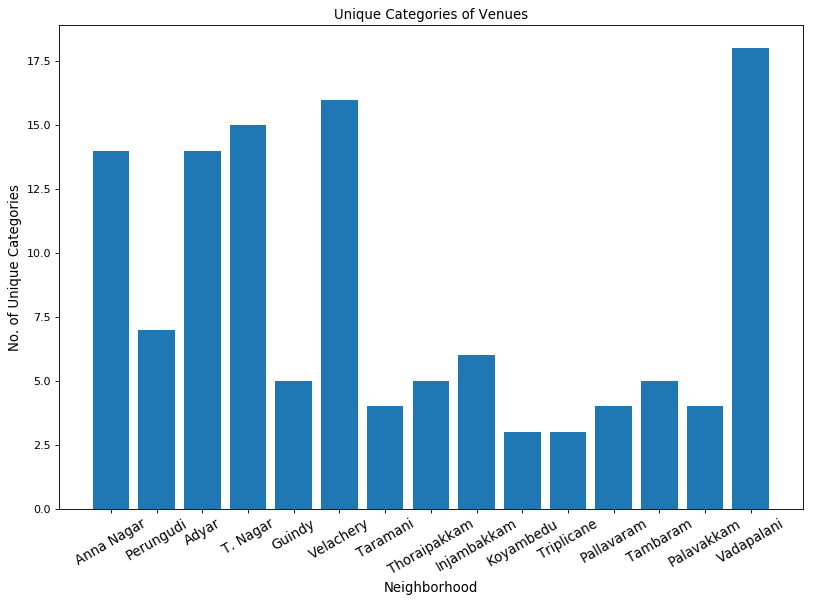

In [20]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

plt.bar(category_count.keys(), category_count.values(), width=0.8)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('No. of Unique Categories', fontsize=12)
plt.xticks(fontsize=12, rotation=30)
plt.title('Unique Categories of Venues')
plt.show()

In [21]:
# one hot encoding
chennai_onehot = pd.get_dummies(chennai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chennai_onehot['Neighborhood'] = chennai_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [chennai_onehot.columns[-1]] + list(chennai_onehot.columns[:-1])
chennai_onehot = chennai_onehot[fixed_columns]

chennai_onehot.head()

,Neighborhood,Accessories Store,Antique Shop,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Restaurant,Sandwich Place,Shopping Mall,Snack Place,South Indian Restaurant,Tea Room,Theme Restaurant,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Anna Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,Anna Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Anna Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Anna Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Anna Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
chennai_onehot.shape

(169, 65)

In [23]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
chennai_grouped

,Neighborhood,Accessories Store,Antique Shop,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Restaurant,Sandwich Place,Shopping Mall,Snack Place,South Indian Restaurant,Tea Room,Theme Restaurant,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar,0.000000,0.00,0.05,0.000000,0.000000,0.050000,0.000,0.000000,0.050000,...,0.050000,0.050,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000
1,Anna Nagar,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.055556,...,0.000000,0.000,0.000000,0.111111,0.000000,0.0,0.0,0.00,0.055556,0.000000
2,Guindy,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000
3,Injambakkam,0.000000,0.00,0.00,0.166667,0.166667,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000
4,Koyambedu,0.000000,0.25,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000
5,Palavakkam,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000
6,Pallavaram,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.250000,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.25,0.000000,0.000000
7,Perungudi,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,...,0.000000,0.125,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000
8,T. Nagar,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000,0.035714,0.035714,0.035714,0.0,0.0,0.00,0.035714,0.035714
9,Tambaram,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.200000,...,0.000000,0.200,0.000000,0.000000,0.000000,0.2,0.0,0.00,0.000000,0.000000


Let's put together the top 5 venues by frequency in each neighborhood.

In [24]:
num_top_venues = 5

for hood in chennai_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = chennai_grouped[chennai_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adyar----
                  venue  freq
0     Indian Restaurant  0.20
1                  Café  0.15
2           Pizza Place  0.10
3            Food Court  0.05
4  Fast Food Restaurant  0.05


----Anna Nagar----
                  venue  freq
0  Fast Food Restaurant  0.17
1      Department Store  0.11
2           Snack Place  0.11
3    Chinese Restaurant  0.06
4                Bakery  0.06


----Guindy----
               venue  freq
0  Indian Restaurant   0.2
1        Bus Station   0.2
2           Bus Line   0.2
3             Lounge   0.2
4          Pool Hall   0.2


----Injambakkam----
          venue  freq
0          Café  0.17
1   Art Gallery  0.17
2    Art Museum  0.17
3  Burger Joint  0.17
4          Farm  0.17


----Koyambedu----
                       venue  freq
0                Bus Station  0.50
1               Antique Shop  0.25
2           Department Store  0.25
3  Middle Eastern Restaurant  0.00
4                Music Store  0.00


----Palavakkam----
               venue 

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adyar,Indian Restaurant,Café,Pizza Place,Fried Chicken Joint,Restaurant
1,Anna Nagar,Fast Food Restaurant,Department Store,Snack Place,Gym,Market
2,Guindy,Bus Line,Indian Restaurant,Pool Hall,Bus Station,Lounge
3,Injambakkam,Beach,Art Gallery,Art Museum,Burger Joint,Farm
4,Koyambedu,Bus Station,Antique Shop,Department Store,Cafeteria,Food Court


In [27]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adyar,Indian Restaurant,Café,Pizza Place,Fried Chicken Joint,Restaurant
1,Anna Nagar,Fast Food Restaurant,Department Store,Snack Place,Gym,Market
2,Guindy,Bus Line,Indian Restaurant,Pool Hall,Bus Station,Lounge
3,Injambakkam,Beach,Art Gallery,Art Museum,Burger Joint,Farm
4,Koyambedu,Bus Station,Antique Shop,Department Store,Cafeteria,Food Court
5,Palavakkam,Resort,Indian Restaurant,Boarding House,Bar,Women's Store
6,Pallavaram,Train Station,Hotel,Bus Station,Restaurant,Women's Store
7,Perungudi,Chinese Restaurant,Juice Bar,Athletics & Sports,Clothing Store,Sandwich Place
8,T. Nagar,Indian Restaurant,Clothing Store,Jewelry Store,Park,Women's Store
9,Tambaram,Food Court,Bakery,Food,Tea Room,Sandwich Place


## Cluster Neighborhoods

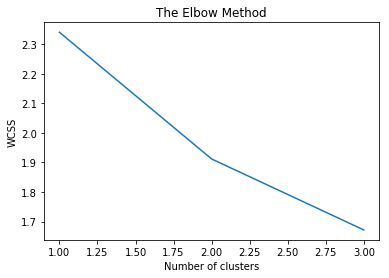

In [28]:
chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)
wcss = []
for i in range(1, 4):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(chennai_grouped_clustering)
    wcss.append (kmeans.inertia_)
plt.plot(range(1, 4), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [29]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1])

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chennai_merged = data

chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

chennai_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Anna Nagar,13.0891,80.2096,1,Fast Food Restaurant,Department Store,Snack Place,Gym,Market
1,Perungudi,12.9654,80.2461,1,Chinese Restaurant,Juice Bar,Athletics & Sports,Clothing Store,Sandwich Place
2,Adyar,13.0012,80.2565,1,Indian Restaurant,Café,Pizza Place,Fried Chicken Joint,Restaurant
3,T. Nagar,13.0405,80.2337,1,Indian Restaurant,Clothing Store,Jewelry Store,Park,Women's Store
4,Guindy,13.0102,80.2157,1,Bus Line,Indian Restaurant,Pool Hall,Bus Station,Lounge


In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Latitude'], chennai_merged['Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Overview of Clusters :

In [32]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Taramani,Cafeteria,Restaurant,Hotel,Platform,Café
7,Thoraipakkam,Restaurant,Vegetarian / Vegan Restaurant,Theme Restaurant,North Indian Restaurant,Bus Station
9,Koyambedu,Bus Station,Antique Shop,Department Store,Cafeteria,Food Court
11,Pallavaram,Train Station,Hotel,Bus Station,Restaurant,Women's Store


In [33]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Anna Nagar,Fast Food Restaurant,Department Store,Snack Place,Gym,Market
1,Perungudi,Chinese Restaurant,Juice Bar,Athletics & Sports,Clothing Store,Sandwich Place
2,Adyar,Indian Restaurant,Café,Pizza Place,Fried Chicken Joint,Restaurant
3,T. Nagar,Indian Restaurant,Clothing Store,Jewelry Store,Park,Women's Store
4,Guindy,Bus Line,Indian Restaurant,Pool Hall,Bus Station,Lounge
5,Velachery,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Clothing Store,Chinese Restaurant
8,Injambakkam,Beach,Art Gallery,Art Museum,Burger Joint,Farm
10,Triplicane,Vegetarian / Vegan Restaurant,Indian Restaurant,Music Store,Food,Fast Food Restaurant
12,Tambaram,Food Court,Bakery,Food,Tea Room,Sandwich Place
13,Palavakkam,Resort,Indian Restaurant,Boarding House,Bar,Women's Store


## Results and Discussion <a name="results"></a>
***
Our analysis shows that restaurants and food courts are the majority occupants in most neighborhoods. High foot traffic can also be mapped to presence of Clothing stores, Department stores and Snack centres which are widely used. 

First cluster has less diverse neighborhoods in terms of variety of categories present. From second cluster, Anna Nagar, Adyar, T.Nagar, Vadapalani and Velachery have more diverse set of venues and therefore will experience high foot traffic compared to other neighborhoods under analysis. These also have more number of venues returned and hence points to the fact that they are indeed attractive neighborhoods. Second cluster neighborhoods are better locations to consider.

## Conclusion <a name="conclusion"></a>
***

A geo-demographic study of the location was conducted to select a spot for an off-site ATM kiosk. Primary criterion under our consideration is potential footfall. Through clustering, we have identified similar set of neighborhoods in Chennai, India and provided the details of various diverse venues in the neighborhood. The stakeholders, Bank executive team, can determine an ideal location based on our analysis.

While the primary criterion is potential footfall, other factors such as rent, adequate power supply, connectivity, availability of parking space for customers’ vehicles, security risk profile of the location and nearest cash feeder branch should be taken into account. 